# Config

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

In [3]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scanpy as sc
import scanpy as sc
import torch
import scipy.spatial
import matplotlib
import matplotlib.patches as mpatches
import string

from omegaconf import OmegaConf
import pytorch_lightning as pl

In [4]:
DATA_PATH = '/braid/havivd/scgen/kang_scimilarity_v2.h5ad'
OBSM_KEY = 'X_pca'
Z_SCORE = False
CONCEPT_KEY = 'concepts'
RANDOM_SEED = 0

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [5]:
# --- Plotting Configuration ---
CT_CMAP = {'naive thymus-derived CD4-positive, alpha-beta T cell': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'FCGR3A+ Monocytes': (0.6823529411764706,
  0.7803921568627451,
  0.9098039215686274),
 'CD14+ Monocytes': (1.0, 0.4980392156862745, 0.054901960784313725),
 'germinal center B cell': (1.0, 0.7333333333333333, 0.47058823529411764),
 'memory B cell': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'CD4-positive, CD25-positive, alpha-beta regulatory T cell': (0.596078431372549,
  0.8745098039215686,
  0.5411764705882353),
 'CD8 T cells': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'NK cell': (1.0, 0.596078431372549, 0.5882352941176471),
 'Dendritic cells': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353)}

STIM_CMAP = {'ctrl': '#fcb6b1', 'stim': '#c44536'}
# IDENT_CMAP = {
#     'train': '#676765', 'held out for intervention': '#c84639',
#     'held out as GT': '#048757', 'intervened on': '#06d400'
# }

IDENT_CMAP = {
    'train': '#676765', 'intervention': '#c84639','held out for intervention': '#c84639',
    'held out as GT': '#048757', 'intervened on': '#06d400'
}

TITLE_MAP = {'cell_types_L2': 'Cell Type', 'stim': 'State', 'ident': 'Split'}

# DATA LOADING AND PREPARATION

In [6]:
def split_data(adata, hold_out_label, mod_label, label_key = 'L2_stim'):
    """
    Splits data into train, intervention, and ground truth sets.

    - Ground Truth: All cells with the `hold_out_label`.
    - Intervention: All cells with the `mod_label`.
    - Train: All remaining cells.
    """
    print("Splitting data with simplified logic...")
    labels = adata.obs[label_key]

    # Define the three disjoint sets based on their labels
    is_test = (labels == hold_out_label)
    is_inter = (labels == mod_label)
    is_train = ~is_test

    # Create AnnData objects for each split
    adata_train = adata[is_train].copy()
    adata_test = adata[is_test].copy()
    adata_inter = adata[is_inter].copy()

    # Store split identifiers in the original object
    ident_vec = np.array(['train'] * len(adata)).astype('<U32')
    ident_vec[is_test] = 'held out as GT'
    ident_vec[is_inter] = 'intervention'
    adata.obs['ident'] = ident_vec
    

    return adata, adata_train, adata_test, adata_inter



# MODELING & PREDICTION METHODS

## Method 1: scCBGM

In [7]:
def train_cbgm(adata_train, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Trains and returns the scCBGM model."""
    print("Training scCBGM model...")

    # --- MODIFICATION START ---
    # Conditionally set the data source and input dimension based on the 'pca' flag
    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    # --- MODIFICATION END ---

    torch.set_flush_denormal(True)

    config = OmegaConf.create(dict(
        has_cbm=True, 
        lr=5e-4, 
        hidden_dim=1024, 
        n_layers = 4,
        beta=1e-5,
        input_dim=data_matrix.shape[-1],  # <-- Use the dynamically set input dimension
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].shape[1],
        n_unknown=128, 
        concepts_hp=0.1, 
        orthogonality_hp=0.5, 
        use_soft_concepts=False
    ))
    model = clab.models.scCBGM(config)

    model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return model

def pred_cbgm(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Performs intervention using a trained scCBGM model."""
    print("Performing intervention with scCBGM...")
    if(obsm_key != 'X'):
        x_intervene_on =  torch.tensor(adata_inter.obsm[obsm_key], dtype=torch.float32)
    else:
        x_intervene_on = torch.tensor(adata_inter.X, dtype=torch.float32)
    c_intervene_on = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)

    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on.to('cuda'), mask=mask.to('cuda'), concepts=inter_concepts.to('cuda'))
    
    inter_preds = inter_preds['x_pred'].cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata


##  Method 2: Flow Matching with Learned Concepts

In [8]:
def get_learned_concepts(scCBGM_model, adata_full, obsm_key = 'X_pca'):
    """Uses a trained scCBGM to generate learned concepts for all data."""
    print("Generating learned concepts from scCBGM...")

    if(obsm_key != 'X'):
        all_x = torch.tensor(adata_full.obsm[obsm_key], dtype=torch.float32).to('cuda')
    else:
        all_x = torch.tensor(adata_full.X, dtype=torch.float32).to('cuda')

    with torch.no_grad():
        enc = scCBGM_model.encode(all_x)
        adata_full.obsm['scCBGM_concepts_known'] = scCBGM_model.cb_concepts_layers(enc['mu']).cpu().numpy()
        adata_full.obsm['scCBGM_concepts_unknown'] = scCBGM_model.cb_unk_layers(enc['mu']).cpu().numpy()

    adata_full.obsm['scCBGM_concepts'] = np.concatenate([adata_full.obsm['scCBGM_concepts_known'], adata_full.obsm['scCBGM_concepts_unknown']], axis=1)
    return adata_full

def train_cb_fm(adata_train, concept_key = 'scCBGM_concepts', obsm_key = 'X_pca'):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Concept Bottleneck Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    
    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].shape[1],
        n_layers=4,
        dropout=0.1,
        p_uncond = 0.0)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model



def pred_cb_fm(model, adata_inter, concept_key = 'scCBGM_concepts', obsm_key = 'X_pca', edit = True):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with CB-FM (learned)...")

    if(obsm_key != 'X'):
        x_inter = adata_inter.obsm[obsm_key]
    else:
        x_inter = adata_inter.X
    
    c_known_inter = adata_inter.obsm[concept_key + '_known'].astype(np.float32)
    c_unknown_inter = adata_inter.obsm[concept_key + '_unknown'].astype(np.float32)
    
    inter_concepts_known = c_known_inter.copy()
    inter_concepts_known[:, -1] = 1 # Set stim concept to 1
    


    init_concepts = np.concatenate([c_known_inter, c_unknown_inter], axis=1)
    edit_concepts = np.concatenate([inter_concepts_known, c_unknown_inter], axis=1)

    # init_concepts = adata_inter.obsm[concept_key].astype(np.float32)
    # edit_concepts = init_concepts.copy()
    # edit_concepts[:, -1] = 1 # Set stim concept to 1

    if(edit):
        inter_preds = model.edit(
                x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
                c = torch.from_numpy(init_concepts.astype(np.float32)).to('cuda'),
                c_prime = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
                t_edit = 0.0,
                n_steps = 1000,
                w_cfg_forward = 1.0,
                w_cfg_backward = 1.0,
                noise_add = 0.0)
    else:
        inter_preds = model.decode(
                h = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
                n_steps = 1000,
                w_cfg = 1.0)
        
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata



## Method 3: Flow Matching with Raw Concepts 

In [9]:
def train_raw_fm(adata_train, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Conditonal Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    
    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].to_numpy().shape[1],
        n_layers=4,
        dropout=0.1,
        p_uncond = 0.0)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model



def pred_raw_fm(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca', edit = False):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with Raw Flow Matching(learned)...")
    init_concepts = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)   
    edit_concepts = init_concepts.copy()
    edit_concepts[:, -1] = 1 # Set stim concept to 1
    
    if(obsm_key != 'X'):
        x_inter = adata_inter.obsm[obsm_key]
    else:
        x_inter = adata_inter.X

    if(edit):
        inter_preds = model.edit(
                x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
                c = torch.from_numpy(init_concepts).to('cuda'),
                c_prime = torch.from_numpy(edit_concepts).to('cuda'),
                t_edit = 0.0,
                n_steps = 1000,
                w_cfg_forward = 1.0,
                w_cfg_backward = 1.0,
                noise_add = 0.0)
    else:
        inter_preds = model.decode(
                h = torch.from_numpy(edit_concepts).to('cuda'),
                n_steps = 1000,
                w_cfg = 1.0)
    
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata




# Method 4: CB FM VAE

In [31]:
def train_cb_fm_vae(adata_train, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Trains and returns the scCBGM model."""
    print("Training cm_fm_vae model...")

    # --- MODIFICATION START ---
    # Conditionally set the data source and input dimension based on the 'pca' flag
    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    # --- MODIFICATION END ---

    torch.set_flush_denormal(True)

    config = OmegaConf.create(dict(
        has_cbm=True, 
        lr=5e-4, 
        hidden_dim=1024, 
        n_layers = 4,
        beta=1e-5,
        input_dim=data_matrix.shape[-1],  # <-- Use the dynamically set input dimension
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].shape[1],
        n_unknown=128, 
        concepts_hp=0.1, 
        orthogonality_hp=0.5, 
        use_soft_concepts=False
    ))
    model = clab.models.CB_VAE_FM(config)

    model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return model

def pred_cb_fm_vae(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Performs intervention using a trained CB_FM_VAE model."""
    print("Performing intervention with CB_FM_VAE...")
    if(obsm_key != 'X'):
        x_intervene_on =  torch.tensor(adata_inter.obsm[obsm_key], dtype=torch.float32)
    else:
        x_intervene_on = torch.tensor(adata_inter.X, dtype=torch.float32)
    c_intervene_on = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)

    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    #mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    #inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on.to('cuda'), mask=mask.to('cuda'), concepts=inter_concepts.to('cuda'))
    
    inter_preds = inter_preds['x_pred'].cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata


# Main

## Proccesing

In [11]:
import sklearn.decomposition

In [12]:
print("Loading and preprocessing data...")
adata = ad.read_h5ad(DATA_PATH)
sc.pp.normalize_total(adata, target_sum=np.median(adata.X.toarray().sum(axis=1)))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset=True)

adata.X = adata.X.toarray()

Loading and preprocessing data...


### Check L1 and L2 cell types

In [13]:
adata.obs['cell_types_L1'] = adata.obs['L1']
adata.obs['cell_types_L2'] = adata.obs['L2']

In [14]:
obs_df = adata.obs.copy()

In [15]:

proportion_crosstab = pd.crosstab(obs_df['cell_types_L2'], obs_df['cell_types_L1'], normalize='index')
proportion_crosstab

cell_types_L1,B cell,Myeloid cell,NK cell,T cell
cell_types_L2,,,,
"CD4-positive, CD25-positive, alpha-beta regulatory T cell",0.0,0.0,0.0,1.0
CD8 T cells,0.0,0.0,0.0,1.0
CD14+ Monocytes,0.0,1.0,0.0,0.0
Dendritic cells,0.0,1.0,0.0,0.0
FCGR3A+ Monocytes,0.0,1.0,0.0,0.0
NK cell,0.0,0.0,1.0,0.0
germinal center B cell,1.0,0.0,0.0,0.0
memory B cell,1.0,0.0,0.0,0.0
"naive thymus-derived CD4-positive, alpha-beta T cell",0.0,0.0,0.0,1.0


In [16]:
row_normalized_crosstab = pd.crosstab(
    obs_df['cell_types_L2'], 
    obs_df['stim'], 
    normalize='index'
)

print("Proportion of each subtype found in 'ctrl' vs. 'stim':")
print((row_normalized_crosstab * 100).round(2))

Proportion of each subtype found in 'ctrl' vs. 'stim':
stim                                                 stim   ctrl
cell_types_L2                                                   
CD4-positive, CD25-positive, alpha-beta regulat...  43.75  56.25
CD8 T cells                                         46.49  53.51
CD14+ Monocytes                                     47.61  52.39
Dendritic cells                                     52.46  47.54
FCGR3A+ Monocytes                                   53.06  46.94
NK cell                                             53.15  46.85
germinal center B cell                              46.51  53.49
memory B cell                                       62.74  37.26
naive thymus-derived CD4-positive, alpha-beta T...  56.61  43.39


In [17]:
thresh_unique = 0.85
thresh_balance = 0.75

max_l1_proportion = proportion_crosstab.max(axis=1)

# Get the names of subtypes that meet the uniqueness threshold.
pure_subtypes = max_l1_proportion[max_l1_proportion > thresh_unique].index


# --- 3. Apply the Balance Filter ---
# Find the max proportion for each L2 subtype across 'ctrl' and 'stim'.
max_condition_proportion = row_normalized_crosstab.max(axis=1)

# Get the names of subtypes that meet the balance threshold.
balanced_subtypes = max_condition_proportion[max_condition_proportion < thresh_balance].index


# --- 4. Find the Intersection ---
# Find the subtypes that are in BOTH lists.
candidate_subtypes = pure_subtypes.intersection(balanced_subtypes)


# --- 5. Display the Results ---
print(f"--- Found {len(candidate_subtypes)} Candidate Subtypes ---")
print(list(candidate_subtypes))

--- Found 9 Candidate Subtypes ---
['CD4-positive, CD25-positive, alpha-beta regulatory T cell', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cell', 'germinal center B cell', 'memory B cell', 'naive thymus-derived CD4-positive, alpha-beta T cell']


### Create Concepts

In [18]:
adata.obs['cell_stim']

AAACATACCATGCA-1    CD4 T cells_ctrl
AAACATACGATGAA-1    CD4 T cells_ctrl
AAACATACGCTTCC-1    CD4 T cells_ctrl
AAACATACGTTGTG-1    CD4 T cells_ctrl
AAACATACTGCGTA-1    CD4 T cells_ctrl
                          ...       
TTTCACGAACTGTG-1       NK cells_stim
TTTCAGTGACGCAT-1       NK cells_stim
TTTCAGTGCGAGAG-1       NK cells_stim
TTTCAGTGTCCGTC-1       NK cells_stim
TTTCCAGAGTCGAT-1       NK cells_stim
Name: cell_stim, Length: 23821, dtype: category
Categories (14, object): ['B cells_ctrl', 'B cells_stim', 'CD4 T cells_ctrl', 'CD4 T cells_stim', ..., 'FCGR3A+ Monocytes_ctrl', 'FCGR3A+ Monocytes_stim', 'NK cells_ctrl', 'NK cells_stim']

In [19]:
adata.obsm[CONCEPT_KEY] = pd.get_dummies(adata.obs[['cell_types_L1', 'stim']]).astype(np.float32)
adata.obsm[CONCEPT_KEY].columns = [col.replace('stim_', '').replace('cell_types_L1_', '') for col in adata.obsm['concepts'].columns]

In [20]:
adata.obsm[CONCEPT_KEY] = adata.obsm[CONCEPT_KEY].drop('ctrl', axis = 1)

### Test Train Split

In [21]:
set(adata.obs['L2'])

{'CD14+ Monocytes',
 'CD4-positive, CD25-positive, alpha-beta regulatory T cell',
 'CD8 T cells',
 'Dendritic cells',
 'FCGR3A+ Monocytes',
 'NK cell',
 'germinal center B cell',
 'memory B cell',
 'naive thymus-derived CD4-positive, alpha-beta T cell'}

In [22]:
hold_out_label = 'Dendritic cells_stim'
mod_label = 'Dendritic cells_ctrl'


adata, adata_train, adata_test, adata_inter = split_data(
    adata, hold_out_label, mod_label
)




Splitting data with simplified logic...


In [23]:
print(f"Train set: {len(adata_train)} cells")
print(f"Intervention set: {len(adata_inter)} cells")
print(f"Ground Truth set: {len(adata_test)} cells")

Train set: 23597 cells
Intervention set: 203 cells
Ground Truth set: 224 cells


In [24]:
adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=128).fit(adata_train.X)

for x_data in [adata, adata_train, adata_test, adata_inter]:
    x_data.uns['pc_transform'] = adata.uns['pc_transform']
    x_data.obsm['X_pca'] = x_data.uns['pc_transform'].transform(x_data.X)



# --- Method 1: scCBGM ---


In [24]:
cbgm_model = train_cbgm(adata_train.copy())


Training scCBGM model...
Starting training on cuda for 200 epochs...


Training Progress: 100%|█████████████████████████████████████| 200/200 [02:48<00:00,  1.19it/s, avg_loss=4.295e-03, concept_f1=1.0000, lr=1.64990e-04]

Training finished.


In [25]:
pred_adata_cbgm = pred_cbgm(cbgm_model, adata_inter.copy())

Performing intervention with scCBGM...


# --- Method 2: CB-FM with Learned Concepts ---


In [26]:
adata_with_concepts = get_learned_concepts(cbgm_model, adata.copy())
# Distribute the newly generated concepts to the training set
adata_train.obsm['scCBGM_concepts'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts']
adata_inter.obsm['scCBGM_concepts'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts']

adata_train.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_known']
adata_train.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_unknown']

adata_inter.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_known']
adata_inter.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_unknown']

Generating learned concepts from scCBGM...


In [27]:
cb_fm_model = train_cb_fm(adata_train.copy())

Training Concept Bottleneck Flow Model
Starting training on cuda for 200 epochs...


Training Progress: 100%|██████| 200/200 [01:45<00:00,  1.90it/s, avg_loss=2.453e-01, lr=1.64990e-04]


In [28]:
pred_adata_fm_edit = pred_cb_fm(cb_fm_model, adata_inter.copy(), edit = True)
pred_adata_fm_guid = pred_cb_fm(cb_fm_model, adata_inter.copy(), edit = False)

Performing intervention with CB-FM (learned)...
Editing from t=1.0 back to t=0.00, then forward with new condition.


Performing intervention with CB-FM (learned)...
Decoding with 1000 steps and CFG scale w=1.0


# --- Method 3: FM with Raw Concepts ---


In [29]:
fm_raw_model = train_raw_fm(adata_train.copy())

Training Conditonal Flow Model
Starting training on cuda for 200 epochs...


Training Progress: 100%|██████| 200/200 [01:45<00:00,  1.90it/s, avg_loss=6.676e-01, lr=1.64990e-04]


In [30]:
pred_adata_raw_fm_edit = pred_raw_fm(fm_raw_model, adata_inter.copy(), edit = True)
pred_adata_raw_fm_guid = pred_raw_fm(fm_raw_model, adata_inter.copy(), edit = False)

Performing intervention with Raw Flow Matching(learned)...
Editing from t=1.0 back to t=0.00, then forward with new condition.


Performing intervention with Raw Flow Matching(learned)...
Decoding with 1000 steps and CFG scale w=1.0


# --- Method 4: CB VAE FM


In [26]:
cb_fm_vae_model = train_cb_fm_vae(adata_train.copy())

Training cm_fm_vae model...
Starting training on cuda for 200 epochs...


Training Progress: 100%|███████████████████████████| 200/200 [03:16<00:00,  1.02it/s, avg_total_loss=7.333e-04, avg_fm_loss=7.333e-04, lr=1.64990e-04]

Training finished.


In [33]:
print(clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm[OBSM_KEY],
    x_ivn=pred_adata_cb_fm_vae.obsm[OBSM_KEY],
    x_target=adata_inter.obsm[OBSM_KEY],
    labels_train=adata_train.obs['cell_stim'].values,
    # pre_computed_mmd_train=1.0
))

{'mmd_ratio': np.float64(24065678.534698498), 'pre_computed_mmd_train': np.float64(0.0)}


In [50]:
with torch.no_grad():
    enc = cb_fm_vae_model.encode(torch.from_numpy(adata_train.obsm['X_pca'].astype('float32')).to('cuda'))
    z_dict = cb_fm_vae_model.reparametrize(**enc)
    cbm_dict = cb_fm_vae_model.cbm(**z_dict)
    x_pred = cb_fm_vae_model.decode(**cbm_dict, n_steps=1000, w_cfg=1.0)


/tmp/ipykernel_2216915/862096472.py:7: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_merge = adata_train.concatenate(adata_pred)
/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


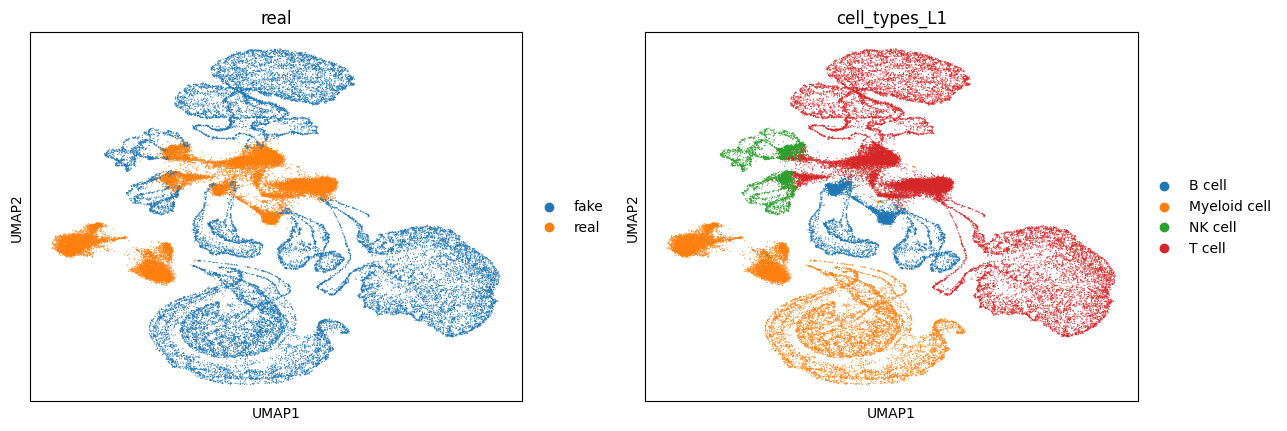

In [53]:

adata_pred = adata_train.copy()
adata_pred.obsm['X_pca'] = x_pred['x_pred'].detach().cpu().numpy()

adata_train.obs['real'] = 'real'
adata_pred.obs['real'] = 'fake'

adata_merge = adata_train.concatenate(adata_pred)
sc.pp.neighbors(adata_merge, use_rep='X_pca')
sc.tl.umap(adata_merge)

sc.pl.umap(adata_merge, color=['real', 'cell_types_L1'])

In [49]:
adata_train

AnnData object with n_obs × n_vars = 23597 × 3000
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes', 'n_counts', 'cell_stim', 'L2', 'L1', 'L1_stim', 'L2_stim', 'cell_types_L1', 'cell_types_L2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pc_transform'
    obsm: 'X_scimilarity', 'X_tsne', 'X_umap', 'concepts', 'X_pca'
    layers: 'counts', 'raw'

# Benchmark

In [30]:
for pred_adata, name in zip([pred_adata_cb_fm_vae],
                            ['scCBGM']):
    print(name)
    print(clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
        x_train=adata_train.obsm[OBSM_KEY],
        x_ivn=pred_adata.obsm[OBSM_KEY],
        x_target=adata_test.obsm[OBSM_KEY],
        labels_train=adata_train.obs['cell_stim'].values,
        # pre_computed_mmd_train=1.0
    ))



scCBGM
{'mmd_ratio': np.float64(2.771515461200095), 'pre_computed_mmd_train': np.float64(0.16658844852845367)}


In [31]:
for pred_adata, name in zip([pred_adata_cbgm, pred_adata_fm_edit, pred_adata_fm_guid, pred_adata_raw_fm_edit,  pred_adata_raw_fm_guid],
                            ['scCBGM', 'CB-FM (edit)', 'CB-FM (guided)', 'Raw-FM (edit)', 'Raw-FM (guided)']):
    print(name)
    print(clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
        x_train=adata_train.obsm[OBSM_KEY],
        x_ivn=pred_adata.obsm[OBSM_KEY],
        x_target=adata_test.obsm[OBSM_KEY],
        labels_train=adata_train.obs['cell_stim'].values,
        # pre_computed_mmd_train=1.0
    ))



scCBGM
{'mmd_ratio': np.float64(0.13849184203982484), 'pre_computed_mmd_train': np.float64(0.16658844852845367)}
CB-FM (edit)
{'mmd_ratio': np.float64(0.13989815900579097), 'pre_computed_mmd_train': np.float64(0.16658844852845367)}
CB-FM (guided)
{'mmd_ratio': np.float64(0.13951567394474543), 'pre_computed_mmd_train': np.float64(0.16658844852845367)}
Raw-FM (edit)
{'mmd_ratio': np.float64(0.25063903781636226), 'pre_computed_mmd_train': np.float64(0.16658844852845367)}
Raw-FM (guided)
{'mmd_ratio': np.float64(1.6480935955037221), 'pre_computed_mmd_train': np.float64(0.16658844852845367)}
